# Predicting Wine Quality, Part 2
Data from http://archive.ics.uci.edu/ml/datasets/Wine+Quality

## Citations
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

Available at:
- [@Elsevier](http://dx.doi.org/10.1016/j.dss.2009.05.016)
- [Pre-press (pdf)](http://www3.dsi.uminho.pt/pcortez/winequality09.pdf)
- [bib](http://www3.dsi.uminho.pt/pcortez/dss09.bib)

Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
wine = pd.read_csv('data/winequality-red.csv')
wine['high_quality'] = pd.cut(wine.quality, bins=[0, 6, 10], labels=[0, 1])

Since we completed our EDA in the [wine.ipynb notebook for last chapter](https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/blob/master/ch_09/wine.ipynb), we will just look at the first 5 rows to refresh our memory of the data rather than repeating the EDA here.

In [3]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,high_quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


## Helper Functions

In [4]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_visual(y_true, y_pred, class_labels, **kwargs):
    """
    Create a confusion matrix heatmap to evaluate classification.

    Parameters: 
        - y_test: The true values for y
        - preds: The predicted values for y
        - class_labels: What to label the classes.
        - kwargs: Additional keyword arguments for `seaborn.heatmap()`

    Returns:
        A confusion matrix heatmap.
    """
    mat = confusion_matrix(y_true, y_pred)
    print('TP to FP ratio: ' + str(round(mat[1,1] / mat[0,1], 2)))
    ax = sns.heatmap(
        mat.T, square=True, annot=True, fmt='d', 
        cbar=True, cmap=plt.cm.Blues, **kwargs
    )
    plt.xlabel('Actual')
    plt.ylabel('Model Prediction')
    tick_marks = np.arange(len(class_labels)) + 0.5
    plt.xticks(tick_marks, class_labels)
    plt.yticks(tick_marks, class_labels, rotation=0)
    plt.title('Confusion Matrix')
    return ax

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc(y_test, preds):
    """
    Plot ROC curve to evaluate classification.

    Parameters: 
        - y_test: The true values for y
        - preds: The predicted values for y

    Returns:
        ROC curve.
    """
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='baseline')
    plt.plot(fpr, tpr, color='red', lw=2, label='model')
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.annotate(f'AUC: {roc_auc_score(y_test, preds):.2}', xy=(.8, .1))

## Train Test Split

In [6]:
from sklearn.model_selection import train_test_split

y = wine.pop('high_quality')
X = wine.drop(columns='quality')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=0, stratify=y
)

## Searching for Best Hyperparameters with GridSearchCV

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
    ('scale', MinMaxScaler()),
    ('lr', LogisticRegression(
        solver='lbfgs', class_weight='balanced', random_state=0
    ))
])

search_space = {
    'lr__C': [0.01, 0.1, 0.25, 0.5, 0.75, 1], # regularization strength
    'lr__fit_intercept' : [True, False]
}
lr_grid = GridSearchCV(pipeline, search_space, scoring='f1', cv=5)
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('lr', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lr__C': [0.01, 0.1, 0.25, 0.5, 0.75, 1], 'lr__fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [8]:
lr_grid.best_estimator_

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('lr', LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

In [9]:
lr_grid.score(X_test, y_test)

0.4444444444444445

In [10]:
lr_preds = lr_grid.predict(X_test)

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lr_preds))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86       138
           1       0.34      0.64      0.44        22

   micro avg       0.78      0.78      0.78       160
   macro avg       0.64      0.72      0.65       160
weighted avg       0.85      0.78      0.81       160



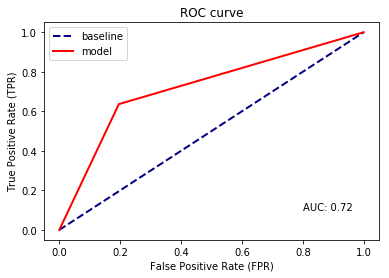

In [12]:
plot_roc(y_test, lr_preds)

TP to FP ratio: 0.52


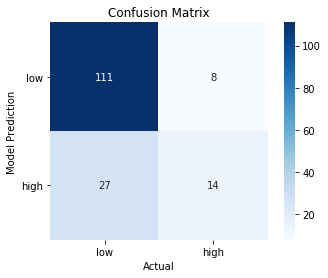

In [13]:
confusion_matrix_visual(y_test, lr_preds, ['low', 'high'])

What are the coefficients?

In [14]:
[(col, coef) for col, coef in zip(X_train.columns, lr_grid.best_estimator_.named_steps['lr'].coef_[0])]

[('fixed acidity', 1.0160786328665312),
 ('volatile acidity', -3.1955460953598407),
 ('citric acid', 1.0047169314539242),
 ('residual sugar', 1.0689280004231967),
 ('chlorides', -1.6826204877134072),
 ('free sulfur dioxide', -0.24555993307108584),
 ('total sulfur dioxide', -1.978805783325783),
 ('density', -2.0968197623169003),
 ('pH', -1.2506930068009292),
 ('sulphates', 2.1798613808787923),
 ('alcohol', 4.432593198942829)]

## Principal Components Analysis
Can we see a way to easily separate these that might help us?

In [15]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def pca_scatter(X, labels, color_map, point_size):
    """Create a 2D scatter plot from 2 PCA components of X"""
    pca = PCA(2, random_state=0).fit(X)
    data = pca.transform(X)
    ax = plt.scatter(
        data[:, 0], data[:, 1],
        c=labels, edgecolor='none', alpha=1,
        cmap=plt.cm.get_cmap(color_map, 2), s=point_size
    )
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.colorbar().set_ticks([0, 1])
    plt.legend(
        ['explained variance\n'
        'comp. 1: {:.3}\ncomp. 2: {:.3}'.format(
            *pca.explained_variance_ratio_
        )]
    )
    return ax
    
def pca_scatter_3d(X, labels, color_map):
    """Create a 3D scatter plot from 3 PCA components of X"""
    pca = PCA(3, random_state=0).fit(X)
    data = pca.transform(X)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter3D(
        data[:, 0], data[:, 1], data[:, 2],
        c=labels, cmap=plt.cm.get_cmap(color_map, 2)
    )
    ax.view_init(elev=10, azim=15)
    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    ax.set_zlabel('component 3')
    fig.colorbar(p).set_ticks([0, 1])
    plt.legend(
        ['explained variance\n'
        'comp. 1: {:.3}\ncomp. 2: {:.3}\ncomp. 3: {:.3}'.format(
            *pca.explained_variance_ratio_
        )]
    )
    return ax

Text(0.5, 0.98, 'Wine Quality PCA (2 components)')

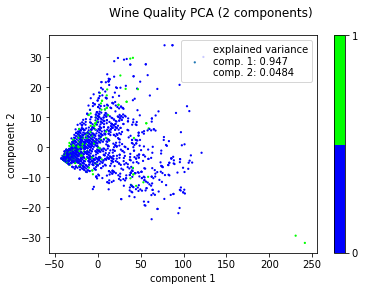

In [16]:
pca_scatter(X, y, 'brg', 5)
plt.suptitle('Wine Quality PCA (2 components)')

Text(0.5, 0.98, 'Wine Quality PCA (3 components)')

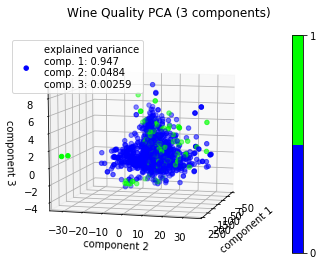

In [17]:
pca_scatter_3d(X, y, 'brg')
plt.suptitle('Wine Quality PCA (3 components)')

Will a model fit on these components perform better?

In [18]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('normalize', MinMaxScaler()),
    ('pca', PCA(2, random_state=0)),
    ('lr', LogisticRegression(
        solver='lbfgs', class_weight='balanced', random_state=0
    ))
]).fit(X_train, y_train)

pipeline.named_steps['lr'].coef_

array([[2.24440661, 6.58246058]])

In [19]:
# agreement with logistic regression alone
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(lr_preds, pipeline.predict(X_test))

0.884297520661157

In [20]:
preds = pipeline.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87       138
           1       0.35      0.64      0.45        22

   micro avg       0.79      0.79      0.79       160
   macro avg       0.64      0.72      0.66       160
weighted avg       0.85      0.79      0.81       160



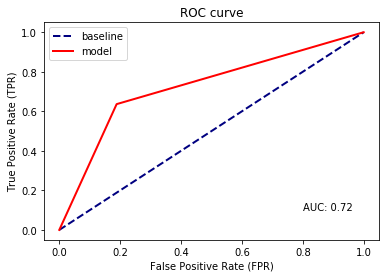

In [21]:
plot_roc(y_test, preds)

TP to FP ratio: 0.54


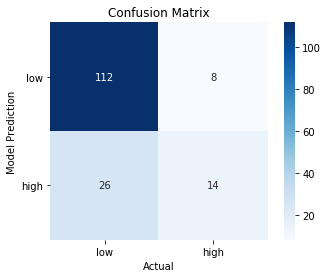

In [22]:
confusion_matrix_visual(y_test, preds, ['low', 'high'])

## Can a decision tree tell us what features are important?

In [23]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
[(col, coef) for col, coef in zip(
    X_train.columns, dt.feature_importances_
)]

[('fixed acidity', 0.07456391612526915),
 ('volatile acidity', 0.11164170070243344),
 ('citric acid', 0.05636227273378047),
 ('residual sugar', 0.08647322339417234),
 ('chlorides', 0.04320703367673604),
 ('free sulfur dioxide', 0.06846924160258594),
 ('total sulfur dioxide', 0.091456317934971),
 ('density', 0.038640305454444836),
 ('pH', 0.09035411465156551),
 ('sulphates', 0.10572727393562266),
 ('alcohol', 0.23310459978841852)]

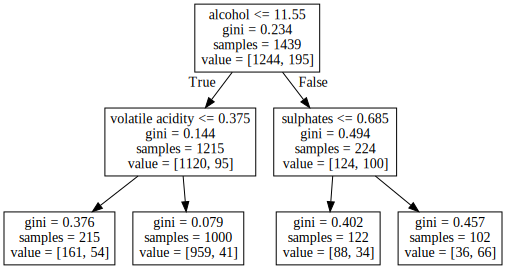

In [24]:
from sklearn.tree import export_graphviz
import graphviz

graphviz.Source(export_graphviz(
    DecisionTreeClassifier(
        max_depth=2, random_state=0
    ).fit(X_train, y_train),
    feature_names=X_train.columns
))

## Ensemble Method: Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators=100, random_state=0)

search_space = {
    'max_depth' : [4, 8],
    'min_samples_leaf' : [4, 6]
}

rf_grid = GridSearchCV(
    rf, search_space, cv=5, scoring='precision'
).fit(X_train, y_train)

rf_preds = rf_grid.predict(X_test)
rf_grid.score(X_test, y_test)

c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6

In [26]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Check agreement between the logistic regression and the random forest range is [-1, 1]

In [27]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(rf_grid.predict(X_test), lr_grid.predict(X_test))

0.3242506811989101

In [28]:
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       138
           1       0.60      0.27      0.37        22

   micro avg       0.88      0.88      0.88       160
   macro avg       0.75      0.62      0.65       160
weighted avg       0.85      0.88      0.85       160



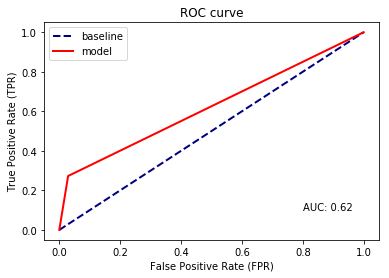

In [29]:
plot_roc(y_test, rf_preds)

TP to FP ratio: 1.5


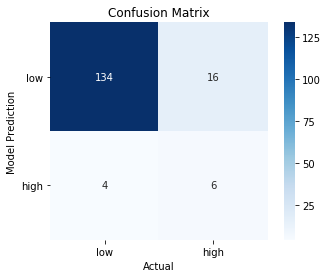

In [30]:
confusion_matrix_visual(y_test, rf_preds, ['low', 'high'])

## Error Analysis

In [31]:
prediction_probabilities = pd.DataFrame(
    rf_grid.predict_proba(X_test), 
    columns=['prob_low', 'prob_high']
).assign(actual=y_test.values)

In [32]:
prediction_probabilities.head()

,prob_low,prob_high,actual
0,0.974619,0.025381,0
1,0.294213,0.705787,1
2,0.662912,0.337088,0
3,0.961213,0.038787,0
4,0.950806,0.049194,0


Confidence on wrong classifications

In [33]:
prediction_probabilities.drop(
    columns='prob_low'
).groupby('actual').apply(
    lambda x: x.nsmallest(5, 'prob_high') if x.name \
        else x.nlargest(5, 'prob_high')
)

prob_high actual
actual                      
0      64    0.569351      0
       51    0.556842      0
       151   0.553207      0
       125   0.524369      0
       139   0.459910      0
1      133   0.032819      1
       146   0.039308      1
       131   0.059572      1
       81    0.078152      1
       69    0.087608      1

Confidence on correct classifications

In [34]:
prediction_probabilities.drop(
    columns='prob_low'
).groupby('actual').apply(
    lambda x: x.nlargest(5, 'prob_high') if x.name \
        else x.nsmallest(5, 'prob_high')
)

prob_high actual
actual                      
0      87    0.012188      0
       17    0.013310      0
       63    0.013369      0
       23    0.013669      0
       96    0.013669      0
1      1     0.705787      1
       159   0.702502      1
       83    0.681131      1
       88    0.624091      1
       40    0.523632      1